<a href="https://colab.research.google.com/github/teaminii/MachineLearning/blob/main/Lec12_Run_Pytorch_on_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q torch==1.0.0 torchvision
import torch
print(torch.__version__)

     |████████████████████████████████| 591.8 MB 616 bytes/s 
     |████████████████████████████████| 21.0 MB 1.2 MB/s 
     |████████████████████████████████| 23.2 MB 50.6 MB/s 
     |████████████████████████████████| 23.3 MB 45.0 MB/s 
     |████████████████████████████████| 23.3 MB 1.3 MB/s 
     |████████████████████████████████| 22.1 MB 1.2 MB/s 
     |████████████████████████████████| 22.1 MB 1.4 MB/s 
     |████████████████████████████████| 17.4 MB 379 kB/s 
     |████████████████████████████████| 17.3 MB 153 kB/s 
     |████████████████████████████████| 12.8 MB 18 kB/s 
     |████████████████████████████████| 12.7 MB 4.4 MB/s 
     |████████████████████████████████| 11.8 MB 34.1 MB/s 
     |████████████████████████████████| 5.9 MB 22.6 MB/s 
     |████████████████████████████████| 6.6 MB 51.0 MB/s 
     |████████████████████████████████| 6.6 MB 31.6 MB/s 
     |████████████████████████████████| 4.0 MB 41.4 MB/s 
     |████████████████████████████████| 10.2 MB 14.3 MB/s 
     |█

In [2]:
##.MINIST 에서 DATASET 다운받고 준비하기 

import torch
from torchvision import datasets, transforms
import torch.nn as nn

batch_size = 128
train_dataset = datasets.MNIST('./data',train = True, download = True, transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,),(0.3081,))]))
test_dataset = datasets.MNIST('./data',train=False, download = True, transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,),(0.3081,))]))
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])

print(len(train_dataset), len(val_dataset), len(test_dataset))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 128, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size = 128, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size = 128, shuffle = False)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

50000 10000 10000


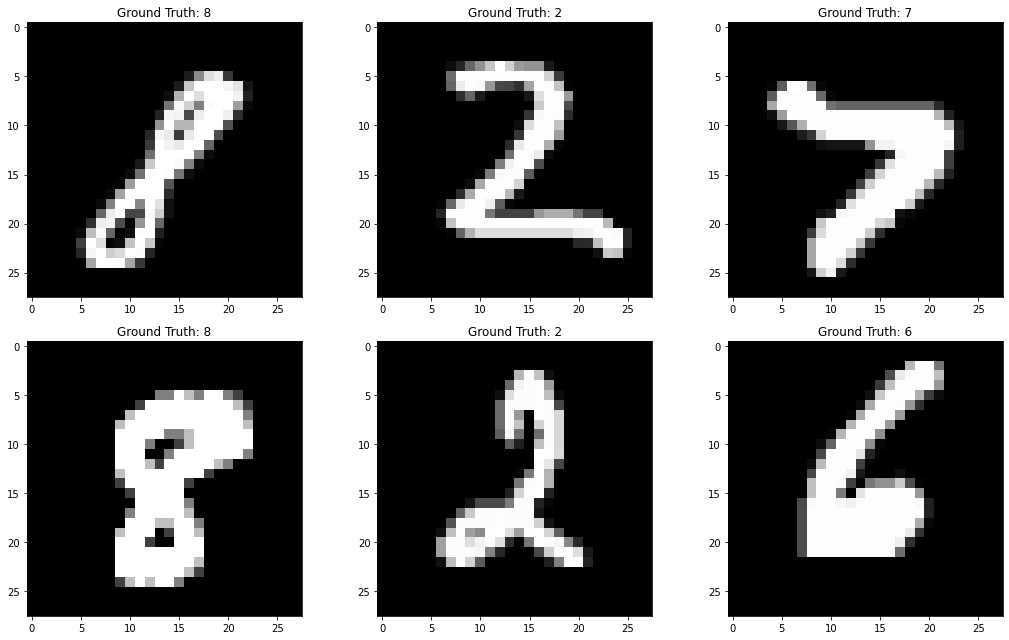

In [3]:
## Inspecting Dataset
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

import matplotlib.pyplot as plt

fig = plt.figure(figsize = (15, 9))
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap = 'gray', interpolation = 'none')
  plt.title("Ground Truth: {}". format(example_targets[i]))
  
  
plt.show()



In [4]:
## Model Architecture
class LinearModel(nn.Module):
  def __init__(self):
    super(LinearModel, self).__init__()
    self.linear = nn.Linear(in_features = 784, out_features = 10, bias = True)


  def forward(self,x):
    x=self.linear(x)
    return x

In [5]:
## Cost Function Define
cls_loss = nn.CrossEntropyLoss()

In [6]:
## pytorch가 GPU 잘 인식되는지 확인

print(torch.cuda.is_available())

True


In [15]:
## Train & Evaluation

import torch.optim as optim
from sklearn.metrics import accuracy_score

import time

#1. Model 만들기 
model = LinearModel()
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'  ##torch.cuda.is_available()가 False 일 때 위험성을 줄이기 위해
model.to(device)
print('Number of {} parameters'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

# 2. Optimizer 만들기
lr = 0.005
optimizer = optim.SGD(model.parameters(), lr=lr)

list_epoch = [] 
list_train_loss = []
list_val_loss = []
list_acc = []
list_acc_epoch = []

epoch = 30
for i in range(epoch):
  ts = time.time()

  #Train
  train_loss = 0
  model.train()

  for input_X, true_y in train_loader:
    optimizer.zero_grad()

    input_X = input_X.squeeze()
    input_X = input_X.view(-1,784)

    ## GPU 이용하기 위해 추가
   

    input_X = input_X.to(device)
    true_y = true_y.to(device)
    ##
    pred_y = model(input_X)

    loss = cls_loss(pred_y.squeeze(), true_y)
    loss.backward()
    optimizer.step()

    ## GPU 이용하기 위해 추가
    train_loss += loss.detach().item()
    ##
  train_loss = train_loss / len(train_loader)
  list_train_loss.append(train_loss)
  list_epoch.append(i)


  #Validation
  val_loss = 0
  model.eval()

  with torch.no_grad():
    for input_X, true_y in val_loader:
      input_X = input_X.squeeze()
      input_X = input_X.view(-1,784)

      ## GPU 이용하기 위해 추가
      input_X = input_X.to(device)
      true_y = true_y.to(device)
      ## 

      pred_y = model(input_X)
      loss = cls_loss(pred_y.squeeze(), true_y)

       ## 방법1. val_loss += loss.detach().cpu().numpy()
       ## 방법2. val_loss += loss.item()
       ## 기존 코드에서 CPU 사용할 때 => val_loss += loss.detach().numpy()
      val_loss += loss.item()
    val_loss = val_loss / len(val_loader)
    list_val_loss.append(val_loss)



  #Evaluation
  correct = 0
  model.eval()

  with torch.no_grad():
    for input_X, true_y in test_loader:
      input_X = input_X.squeeze()
      input_X = input_X.view(-1,784)

      ## GPU 이용하기 위해 추가
      input_X = input_X.to(device)
      true_y = true_y.to(device)
      ## 

      pred_y = model(input_X).max(1,keepdim = True)[1].squeeze()
      correct += pred_y.eq(true_y).sum()

    # CPU일 때 : acc = correct.numpy() / len(test_loader.dataset)
    acc = correct.item() / len(test_loader.dataset)

    list_acc.append(acc)
    list_acc_epoch.append(i)

  te = time.time()
  print(te-ts)
     

  print('Epoch: {}, Train Loss: {}, Val Loss: {}, Test Acc: {}% , {:3.1f} '.format(i, train_loss, val_loss, acc*100, te-ts))   # . 앞으로는 3자리, 뒤로는 1자리 까지만 

Number of 7850 parameters
10.427340984344482
Epoch: 0, Train Loss: 0.7557412230450175, Val Loss: 0.47533226239530346, Test Acc: 88.14% , 10.4 
10.335720300674438
Epoch: 1, Train Loss: 0.4410185543701167, Val Loss: 0.40032602299617814, Test Acc: 89.60000000000001% , 10.3 
10.54912519454956
Epoch: 2, Train Loss: 0.39236106420569405, Val Loss: 0.36928234032437773, Test Acc: 90.25999999999999% , 10.5 
10.392961978912354
Epoch: 3, Train Loss: 0.3679099378302274, Val Loss: 0.35142784575118297, Test Acc: 90.60000000000001% , 10.4 
10.315574169158936
Epoch: 4, Train Loss: 0.35243537728591345, Val Loss: 0.33913389848002906, Test Acc: 90.96% , 10.3 


TypeError: ignored